### IBM Advanced Data Science Capstone Project

#### Salvatore Salpietro

Building a classifier to detect diseased lung from chest x-ray images.

##### Summary

TODO

In [1]:
from skimage import io #allows to read images
from matplotlib import pyplot
from pathlib import Path
from natsort import natsorted, ns # natural sorting

import pandas as pd
import statistics
import random
import os

In [2]:
# Retrieving the geometry of the image and the number of pixels
# Images in scikit-image are represented by NumPy ndarrays. 
# Hence, many common operations can be achieved using standard NumPy methods for manipulating arrays
#print(xray.shape)
#print(xray.size)

In [3]:
# Retrieving statistical information about image intensity values:
#print(xray.min(), xray.max())
#print(xray.mean())

### Data analysis step

Determine the characteristics of the data and statistics 

#### 1. Data source

Data was obtained from the following source 
https://data.mendeley.com/datasets/rscbjbr9sj/3

We are provided with an archive file containing a set of chest x-rays.  Images are provided in two separate folders, test and train.  Within those folders images are separated into two classes - normal and pneumonia.  

#### 2. Characteristics of files

In [4]:
sizes = [] # sizes in kb
all_extensions = set([])
filenum = []
count = 0

test_images = []
test_labels = []

train_images = []
train_labels = []

#training set
for root, dirs, files in os.walk("E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\\assignment\data\chest_xray\\train"):
    #print('dirs', dirs)
    for name in files:
        #print('name', name)
        #print(os.path.basename(root))
        
        file_name, file_extension = os.path.splitext(name)
        all_extensions.add(file_extension)
        
        stats = os.stat(os.path.join(root, name))
        count = count + 1
        
        sizes.append(stats.st_size/1000) 
        
        #if(stats.st_size/1000 < 12):
        #    discarded.append(os.path.join(root, name))
        #else:
        train_images.append(os.path.join(root, name))
        train_labels.append(os.path.basename(root))
        
        filenum.append(count)

#test set
for root, dirs, files in os.walk("E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\\assignment\data\chest_xray\\test"):
    #print('dirs', dirs)
    for name in files:
        #print('name', name)
        #print(os.path.basename(root))
        
        file_name, file_extension = os.path.splitext(name)
        all_extensions.add(file_extension)

        stats = os.stat(os.path.join(root, name))
        count = count + 1
        
        sizes.append(stats.st_size/1000)
        
        #if(stats.st_size/1000 < 12):
        #    discarded.append(os.path.join(root, name))
        #else:
        test_images.append(os.path.join(root, name))
        test_labels.append(os.path.basename(root))
        
        filenum.append(count)

##### 2.1. File names

File names for images of dieases lungs contain a unique anonymized person number as well as the text 'bacteris' or 'virus' indicating if the pnemonia was caused by a virus or bacteris.  Example person426_virus_873

File names for images of normal lungs contain the work 'NORMAL'. Example - NORMAL2-IM-1250-0001

##### 2.2. File extensions

In [5]:
print(all_extensions)

{'.jpeg'}


Files are all the same type - jpeg

##### 2.3. Total number of image files

In [6]:
total_image_files = len(train_images) + len(test_images)

In [7]:
print(total_image_files)

5856


There are a total of 5856 files across both folders (test and train)

##### 2.4. Distribution of image files in test and train folders

In [8]:
len(test_images)

624

In [9]:
len(train_images)

5232

Train / Test split is about 89.4 / 10.6. 

#### 4. Size of the images

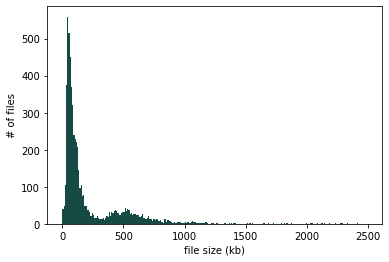

In [10]:
import matplotlib.pyplot as plt

b = [i for i in range(0,2500,10)]

plt.xlabel('file size (kb)')
plt.ylabel('# of files')
plt.hist(sizes, bins=b,  color='#184A45FF')
plt.show()

Above is a histogram plot to show the ditribution of file sizes.  Most of the files are of size less than 1000 kb.

In [11]:
avg = sum(sizes)/len(sizes)
print(avg)

211.14802015027237


In [12]:
print(statistics.median(sizes))

95.839


In [13]:
print(min(sizes))

5.441


In [14]:
print(max(sizes))

2414.342


The mean file size is 211.148

The median file size is 95.839

The minimum file size observed is 5.441 kb

The maximum file size observed is 2412.342 kb

Sonce the file sizes are not all the same, some examination of the really small ans really large image files revealed that the really small images aspect ratio did not match those of the majority of images (i.e. they were longer in width than height and did not reveal the full chest/lung view).  These images might be considered outliers.  Further examination of the images below will attempt to exclude such outliers.  

#### 4. Aspect ratio of the images

The aspect ratio of an image is the ratio of its width to its height.
The formula is width / height.

Not all the images are of the same aspect ratio. On examining some of the images of smaller size, some did not show the full view of the chest and lungs.  We will remove these images.

If the shape of the image is longer in the x axis than it is in the y axis by certain threshold, then discard those images as they only show a section of the full chest image.

Choose something x/y must be less than or equal to 2 to constitute an acceptible image. (i.e. if the width is two or more times longer than the height then discard image)

In [15]:
temp_train_images = []
temp_train_labels = []

temp_test_images = []
temp_test_labels = []

discarded = []

for i in range(len(train_images)):
    xray = io.imread(train_images[i])
    y = xray.shape[0]
    x = xray.shape[1]
    ratio = x/y
    if ratio <= 2:
        temp_train_images.append(train_images[i])
        temp_train_labels.append(train_labels[i])
    else:
        discarded.append(train_images[i])
        
for i in range(len(test_images)):
    xray = io.imread(test_images[i])
    y = xray.shape[0]
    x = xray.shape[1]
    ratio = x/y
    if ratio <= 2:
        temp_test_images.append(test_images[i])
        temp_test_labels.append(test_labels[i])
    else:
        discarded.append(test_images[i])

In [16]:
print('updated train set, labels ', len(temp_train_images), len(temp_train_labels))
print('updated test set, labels ', len(temp_test_images), len(temp_test_labels))
print('discarded images ', len(discarded))

updated train set, labels  5116 5116
updated test set, labels  614 614
discarded images  126


Compare a discarded image to a remaining image in train set.

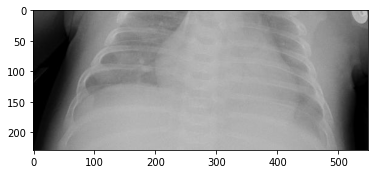

(229, 549, 3)


In [17]:
import matplotlib.pyplot as plt
im = io.imread(discarded[35])
imgplot = plt.imshow(im, cmap="gray")
plt.show()
print(im.shape)

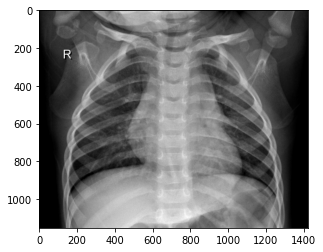

(1152, 1422)


In [18]:
im = io.imread(temp_train_images[1])
imgplot = plt.imshow(im, cmap="gray")
plt.show()
print(im.shape)

#### 4. Redistribute data to a train/validation/test split of 85/15/15

Now that the outliers have been removed, we can redistribute the data set to add some more images to the test set to bring the value up to 15%, and then split the remaining test set into a test and validation split of 85/15.

We won't touch the images in the test set, rather we will simply move some of the ones from the train set into the test set.

Using 15% instead of 20% because we son't have that many images to work with.

In [19]:
# new ratios after removing some outliers

total = len(temp_train_images) + len(temp_test_images)
print('total images = ', total)

percent_test = len(temp_test_images)/total
print('percent test ', percent_test*100)

percent_train = len(temp_train_images)/total
print('percent train ', percent_train*100)

total images =  5730
percent test  10.715532286212914
percent train  89.28446771378708


In [20]:
# calculate number of images to move from train set to test set

needed = 0.15*total
print(needed)

have = len(temp_test_images)
print(have)

difference = needed - have
print("need to add an additional ", difference, " images")

859.5
614
need to add an additional  245.5  images


In [21]:
# convert to pandas dataframe

# train set
data_train = {'file':temp_train_images,'label':temp_train_labels}
train_df = pd.DataFrame(data_train)

# test set
data_test = {'file':temp_test_images,'label':temp_test_labels}
test_df = pd.DataFrame(data_test)

In [22]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
5111,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5112,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5113,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5114,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [23]:
train_df['file'][2000], train_df['label'][2000]

('E:\\COURSES\\Advanced Data Science With IBM\\Advanced Data Science Capstone\\assignment\\data\\chest_xray\\train\\PNEUMONIA\\person1326_bacteria_3372.jpeg',
 'PNEUMONIA')

In [24]:
test_df['file'][200], test_df['label'][200]

('E:\\COURSES\\Advanced Data Science With IBM\\Advanced Data Science Capstone\\assignment\\data\\chest_xray\\test\\NORMAL\\NORMAL2-IM-0340-0001.jpeg',
 'NORMAL')

In [25]:
# first shuffle rows in train dataframe
train_df = train_df.sample(n = len(train_df)).reset_index(drop=True)

In [26]:
# then move 245 rows from train dataframe to test dataframe
transferdata_df = train_df.iloc[-245:, 0:]

test_df = test_df.append(transferdata_df)

train_df = train_df.drop(transferdata_df.index)

In [27]:
# reset index of test_df
test_df = test_df.reset_index(drop=True)

In [28]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
...,...,...
4866,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4867,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4868,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4869,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [29]:
test_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
854,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
855,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
856,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
857,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [30]:
# split train set further into train and validation set

newtrain_df = train_df.sample(frac=0.85,random_state=200) #random state is a seed value
validation_df = train_df.drop(newtrain_df.index)

In [31]:
train_df = newtrain_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [32]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
4135,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4136,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4137,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4138,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL


In [33]:
validation_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
...,...,...
726,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
727,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
728,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
729,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL


We now have three data sets
- train_df (training set)
- validation_df (validation set)

- test_df (final test set)

#### 5. Shape and color of images

In [34]:
x = []
y = []
z = []
listofdataframes = [train_df, validation_df, test_df]

for df in listofdataframes:
    for index, row in df.iterrows():
        image = row['file']
        s = io.imread(image)
        x.append(s.shape[0])
        y.append(s.shape[1])
        if(len(s.shape) == 3):
            z.append(1)
        else:
            z.append(0)

In [35]:
import numpy as np
import pandas as pd

df = pd.DataFrame({'x': x,
                   'y': y,
                   'z': z})

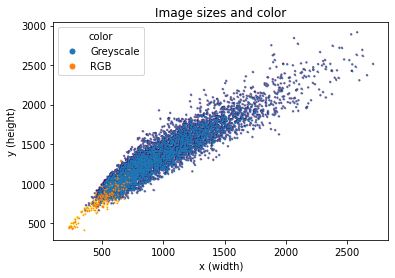

In [36]:
area = 2
plt.scatter(x, y, c=df.z, s=area,  alpha=0.5)
plt.title('Image sizes and color')
plt.xlabel('x (width)')
plt.ylabel('y (height)')
classes = [ 'Greyscale', 'RGB']
groups = df.groupby('z')
for name, group in groups:
    name = classes[0] if name == 0 else classes[1]
    plt.plot(group.x, group.y, marker='.', linestyle='', markersize=1, label=name)

plt.legend(title="color", markerscale=10)

plt.show()

 Since all the images are of different sizes, it will be necessary to reshape them to the same size.
 Also some are greyscale while other are RGB, so it will be necessary to normalize all images to the same color space (greyscale) 

## Data Preprocessing

The following steps need to be done in the data preprocessing step

#### Data Normalization Step

We perform a grayscale normalization to reduce the effect of illumination's differences.
Divide values by 255 to get a value between 0 and 1. 

#### Image Resize
images need to be resized to the same size - both training and test set

NOTE: this step will be done within train_datagen.flow_from_dataframe function by setting parameter 'target_size'

This is an example using skimage (we are not using this here)

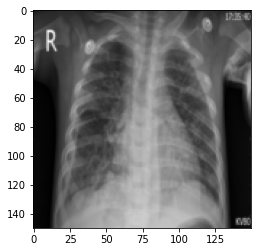

(150, 150)


In [37]:
from skimage.transform import resize
img = io.imread(train_df['file'][0])
img_rescaled = resize(img, (150,150))

imgplot = plt.imshow(img_rescaled, cmap="gray")
plt.show()
print(img_rescaled.shape)

### Image Augmentation Step

In order to avoid overfitting problem, alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [38]:
import tensorflow as tf
print(tf.__version__)


2.4.0


In [40]:
from keras.preprocessing.image import ImageDataGenerator

#### 1. Preprocessing the Training Set

Transformation on the images of the training set to avoid overfitting (data augmentation - see above)

In [41]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.05,
        horizontal_flip=True,
        width_shift_range=0.05,
        height_shift_range=0.05)

In [42]:
train_set = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col="file",
    y_col="label",
    weight_col=None,
    target_size=(128, 128),
    color_mode="grayscale",
    classes=None,
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
)

Found 4140 validated image filenames belonging to 2 classes.


#### 2. Preprocesing the validation and test set

Here we need to keep the images as they were with no modifications but we have to feature scale the images to match the feature scaling done to the test images.

In [44]:
test_datagen = ImageDataGenerator(
        rescale=1./255
        )

In [45]:
validation_datagen = ImageDataGenerator(
        rescale=1./255
        )

In [46]:
validation_set = validation_datagen.flow_from_dataframe(
    validation_df,
    directory=None,
    x_col="file",
    y_col="label",
    weight_col=None,
    target_size=(128, 128),
    color_mode="grayscale",
    classes=None,
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
)

Found 731 validated image filenames belonging to 2 classes.


In [47]:
test_set = test_datagen.flow_from_dataframe(
    test_df,
    directory=None,
    x_col="file",
    y_col="label",
    weight_col=None,
    target_size=(128, 128),
    color_mode="grayscale",
    classes=None,
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
)

Found 859 validated image filenames belonging to 2 classes.


### Building the CNN

#### 1. Convolution

In [48]:
cnn = tf.keras.models.Sequential()

In [49]:
cnn.add(tf.keras.layers.Conv2D(filters=32, 
                               kernel_size=3,
                               activation='relu',
                               input_shape=(128,128,1)
                              ))

#### 2. Pooling

In [50]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

#### Add a second Convolutional Layer

In [51]:
cnn.add(tf.keras.layers.Conv2D(filters=32, 
                               kernel_size=3,
                               activation='relu'
                              ))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

#### 3. Flattening

In [52]:
cnn.add(tf.keras.layers.Flatten())

#### 4. Full Connection

In [53]:
#units = number of hidden neurons - larger number better for images
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

#### 5. Output Layer

In [54]:
#units = 1 for binary classification
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

### Training The CNN

#### 1. Compiling the CNN

In [55]:
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### 2. Training the CNN and Evaluating

In [ ]:
# validation_split is the fraction of training data to use as validation data
# Float between 0 and 1. Fraction of the training data to be used as validation data. 
# The model will set apart this fraction of the training data, will not train on it, 
# and will evaluate the loss and any model metrics on this data at the end of each epoch. 
# The validation data is selected from the last samples in the x and y data provided, before shuffling

# NOTE - cannot use the validation_split when using data set generators so need to split the dataframe manually
# see above 

cnn.fit(x = train_set, validation_data = validation_set, epochs=25 )


Epoch 1/25
130/130 [==============================] - 31s 239ms/step - loss: 0.5322 - accuracy: 0.7189 - val_loss: 0.1379 - val_accuracy: 0.9412
Epoch 2/25
130/130 [==============================] - 31s 240ms/step - loss: 0.2007 - accuracy: 0.9151 - val_loss: 0.1531 - val_accuracy: 0.9343
Epoch 3/25
130/130 [==============================] - 31s 235ms/step - loss: 0.1550 - accuracy: 0.9328 - val_loss: 0.1001 - val_accuracy: 0.9617
Epoch 4/25
 32/130 [======>.......................] - ETA: 20s - loss: 0.1500 - accuracy: 0.9411